<a href="https://colab.research.google.com/github/costpetrides/Forecasting-Temperature-with-Prophet-and-ML-Models/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)


df = pd.read_csv("/content/DailyDelhiClimateTrain.csv",
                 parse_dates=['date'],  # change to date time format
                 index_col="date")


df = df[['meantemp', 'humidity', 'wind_speed']]
df.head()

,meantemp,humidity,wind_speed
date,,,
2013-01-01,10.000,84.500,0.000
2013-01-02,7.400,92.000,2.980
2013-01-03,7.167,87.000,4.633
2013-01-04,8.667,71.333,1.233
2013-01-05,6.000,86.833,3.700


In [42]:
train_size = int(len(df) * 0.8)
dl_train, dl_test = df.iloc[:train_size], df.iloc[train_size:]
print(f"Train - dataset size: {len(dl_train):.2f}")
print(f"Test - dataset size: {len(dl_test):.2f}")

Train - dataset size: 1169.00
Test - dataset size: 293.00


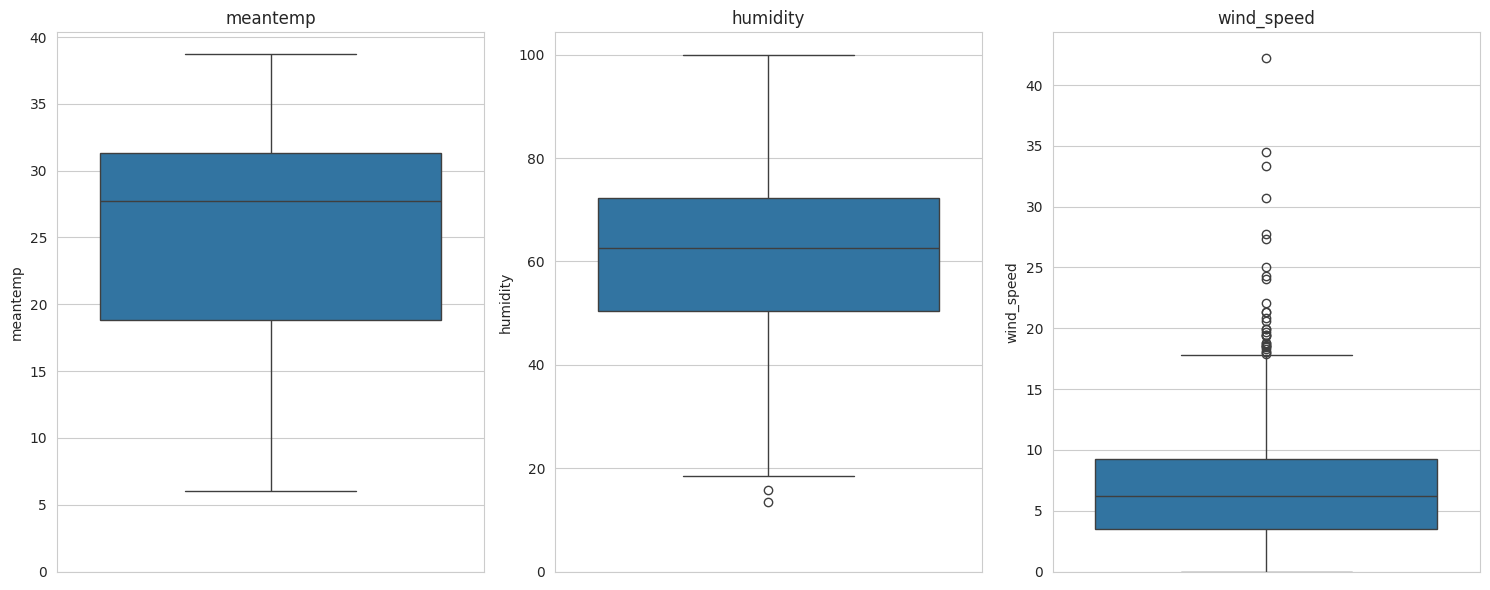

In [43]:
# Choosing the right scaling technique
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['meantemp'])
plt.title('meantemp')
plt.ylim(bottom=0)

plt.subplot(1, 3, 2)
sns.boxplot(y=df['humidity'])
plt.title('humidity')
plt.ylim(bottom=0)

plt.subplot(1, 3, 3)
sns.boxplot(y=df['wind_speed'])
plt.title('wind_speed')
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

1. **MinMax** scaling for meantemp and humidity
2. **Robust** scaling for wind_speed

In [44]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
target_transformer = MinMaxScaler()


dl_train['wind_speed'] = robust_scaler.fit_transform(dl_train[['wind_speed']])  #  wind_speed
dl_train['humidity'] = minmax_scaler.fit_transform(dl_train[['humidity']]) #  humidity
dl_train['meantemp'] = target_transformer.fit_transform(dl_train[['meantemp']]) # target - meantemp

dl_test['wind_speed'] = robust_scaler.transform(dl_test[['wind_speed']])
dl_test['humidity'] = minmax_scaler.transform(dl_test[['humidity']])
dl_test['meantemp'] = target_transformer.transform(dl_test[['meantemp']])

In [45]:
!pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [46]:
sequence_length = 3
X_train, y_train = create_dataset(dl_train, dl_train['meantemp'], sequence_length)
X_test, y_test = create_dataset(dl_test, dl_test['meantemp'], sequence_length)


rnn_model = Sequential()
rnn_model.add(SimpleRNN(100, activation='tanh', input_shape=(sequence_length, X_train.shape[2])))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = rnn_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=1, callbacks=[early_stopping])

# Evaluate the model
loss = rnn_model.evaluate(X_test, y_test)
print(f'Validation Loss: {loss}')

Epoch 1/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0317 - val_loss: 0.0042
Epoch 2/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0082 - val_loss: 0.0047
Epoch 3/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0042 - val_loss: 0.0092
Epoch 4/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 5/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 6/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 7/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 8/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 9/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 10/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 11/30
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 12/30
1166/1166 ━━━━━

In [47]:
# Lets make some predictions !
rnn_pred = rnn_model.predict(X_test)
rnn_pred = target_transformer.inverse_transform(rnn_pred)  # Inverse transform to original scale

# Inverse transform the true values for comparison
y_test = y_test.reshape(-1, 1)
y_test = target_transformer.inverse_transform(y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [48]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, rnn_pred))
r2 = r2_score(y_test, rnn_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

RMSE: 1.650559354623895
R2 Score: 0.9151938269699431


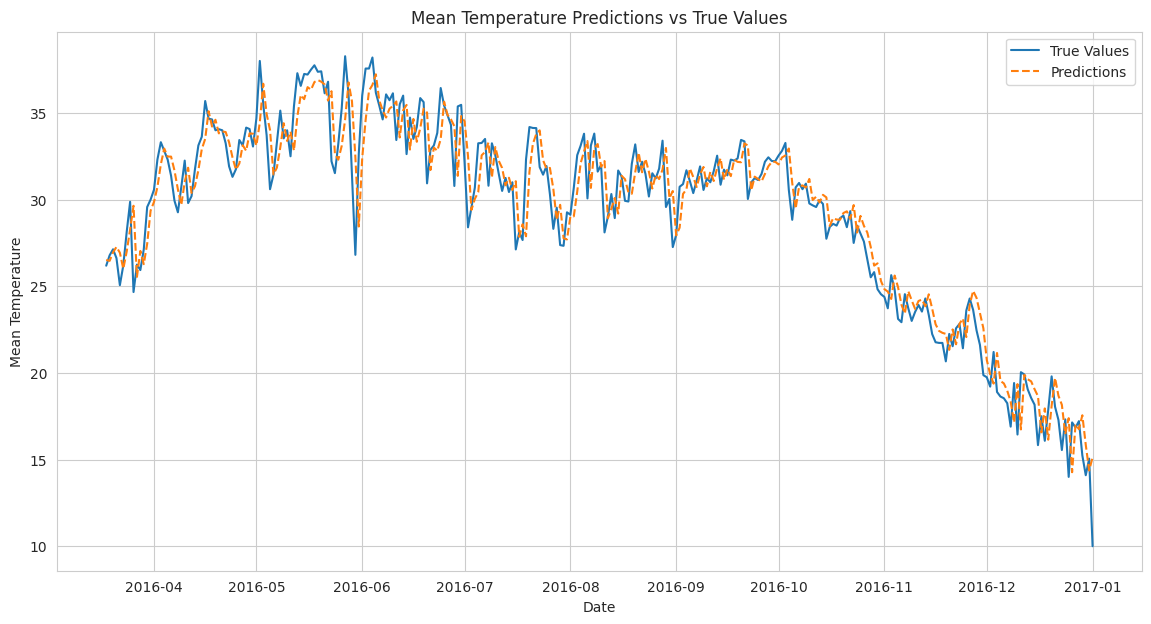

In [49]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Values')
plt.plot(df.index[-len(y_test):], rnn_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

In [50]:
rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 100)                 │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,505 (123.07 KB)

 Trainable params: 10,501 (41.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,004 (82.05 KB)

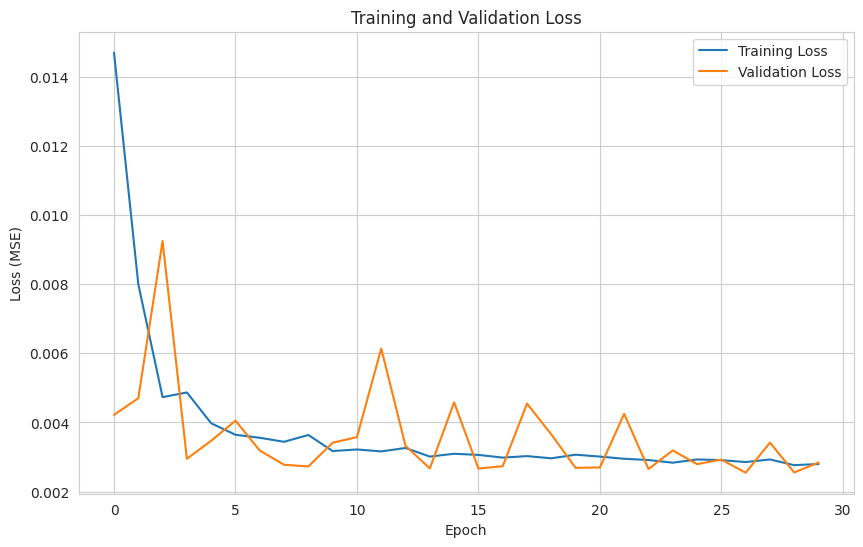

In [51]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()